In [1]:
from pathlib import Path
import numpy as np
import torch

from bbhnet.architectures import Preprocessor, architecturize, ResNet
from gwpy.timeseries import TimeSeriesDict
from ml4gw.utils.slicing import unfold_windows
import matplotlib.pyplot as plt

/home/ethan.marx/miniconda3/envs/bbhnet-datagen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def integrate(x: torch.Tensor, w: torch.Tensor) -> np.ndarray:
    y = torch.nn.functional.conv1d(
        x[None, None], w[None, None], padding="valid"
    )
    return y[0, 0].detach().numpy()

In [4]:
channels = ['H1:GDS-CALIB_STRAIN', 'L1:GDS-CALIB_STRAIN']
event_time = 1367030137
sample_rate = 2048
inference_sampling_rate = 16
kernel_length = 2
kernel_size = int(kernel_length * sample_rate)
stride = int(sample_rate / inference_sampling_rate)
integration_window_length = 1

In [5]:
integrator_size = int(integration_window_length * inference_sampling_rate)
integrator = torch.ones((integrator_size,)) / integrator_size

In [6]:
outdir = Path("/home/ethan.marx/bbhnet/online-experiment")
weights_path = outdir / "training" / "weights.pt"
fduration = 1

In [7]:
nn = ResNet(
    2, layers = [2, 2, 2, 2], norm_groups = 8
)

In [8]:
ifos = ["H1", "L1"]
num_ifos = len(ifos)

preprocessor = Preprocessor(num_ifos, sample_rate, fduration=fduration)
model = torch.nn.Sequential(preprocessor, nn)

weights = torch.load(weights_path, map_location=torch.device('cpu') )
model.load_state_dict(weights)
model.eval()

Sequential(
  (0): Preprocessor(
    (whitener): Whitening(
      (conv_op): _Conv1d()
    )
  )
  (1): ResNet(
    (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): GroupNorm()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (residual_layers): ModuleList(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): GroupNorm()
          (relu): ReLU(inplace=True)
          (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn2): GroupNorm()
        )
        (1): BasicBlock(
          (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): GroupNorm()
          (relu): ReLU(inplace=True)
          (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn2): 

In [9]:
data = TimeSeriesDict.fetch(channels, event_time - 4, event_time + 4).resample(sample_rate)

/home/ethan.marx/miniconda3/envs/bbhnet-datagen/lib/python3.9/site-packages/gwpy/timeseries/core.py:1128: NDSWarning: unique NDS2 channel match not found for 'H1:GDS-CALIB_STRAIN'
  warnings.warn(error.split('\n', 1)[0],


In [10]:
stacked = np.stack(data.values()).value

/home/ethan.marx/miniconda3/envs/bbhnet-datagen/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [11]:
stacked = torch.Tensor(stacked)

In [29]:
data = np.stack(data).value

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [14]:
batch = unfold_windows(stacked, kernel_size, stride)
y = model(batch)[:, 0]
integrated = integrate(y, integrator)

In [15]:
max(integrated)

8.873853

AttributeError: 'list' object has no attribute 'save'

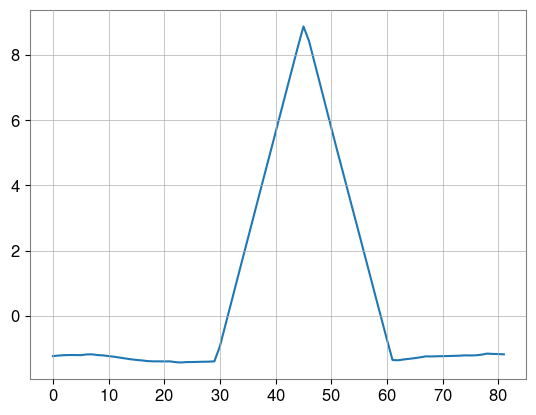

In [18]:
fig = plt.plot(integrated)
fig.save("test.png")

In [50]:
kernel_size

4096